# Import libraries

In [50]:
from pandas import set_option, read_csv, DataFrame
from matplotlib.pyplot import subplots
from seaborn import boxplot, heatmap
from numpy import arange
from sklearn.model_selection import train_test_split, RepeatedKFold
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Load data and initial inspection

In [51]:
"""
Flight Take-Off Data - JFK Airport
https://www.kaggle.com/datasets/deepankurk/flight-take-off-data-jfk-airport/data

This data set contains flight departure information from JKF ariport for the period Nov, Dec & Jan (year unspecified in dataset).
However, the following is stated on the website: "This file contains data about flights leaving from JKF ariport between Nov 2019-Dec-2020."

Taxi-Out prediction is an important concept as it helps in calculating runway time and directly impacts flight/operation costs/efficiencies.
"""

jfk_df = read_csv('/Users/timbo/Coding/DS Bootcamp Playground/jfk_flights.csv')

set_option('display.max_columns', None)  # Force show/display all columns of dataframe

print(jfk_df.shape)
print(jfk_df.columns)
jfk_df.head()

(28820, 23)
Index(['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_UNIQUE_CARRIER', 'TAIL_NUM',
       'DEST', 'DEP_DELAY', 'CRS_ELAPSED_TIME', 'DISTANCE', 'CRS_DEP_M',
       'DEP_TIME_M', 'CRS_ARR_M', 'Temperature', 'Dew Point', 'Humidity',
       'Wind', 'Wind Speed', 'Wind Gust', 'Pressure', 'Condition', 'sch_dep',
       'sch_arr', 'TAXI_OUT'],
      dtype='object')


,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,TAIL_NUM,DEST,DEP_DELAY,CRS_ELAPSED_TIME,DISTANCE,CRS_DEP_M,DEP_TIME_M,CRS_ARR_M,Temperature,Dew Point,Humidity,Wind,Wind Speed,Wind Gust,Pressure,Condition,sch_dep,sch_arr,TAXI_OUT
0,11,1,5,B6,N828JB,CHS,-1,124,636,324,323,448,48,34,58,W,25,38,29.86,Fair / Windy,9,17,14
1,11,1,5,B6,N992JB,LAX,-7,371,2475,340,333,531,48,34,58,W,25,38,29.86,Fair / Windy,9,17,15
2,11,1,5,B6,N959JB,FLL,40,181,1069,301,341,482,48,34,58,W,25,38,29.86,Fair / Windy,9,17,22
3,11,1,5,B6,N999JQ,MCO,-2,168,944,345,343,513,48,34,58,W,25,38,29.86,Fair / Windy,9,17,12
4,11,1,5,DL,N880DN,ATL,-4,139,760,360,356,499,46,32,58,W,24,35,29.91,Fair / Windy,9,17,13


In [52]:
jfk_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28820 entries, 0 to 28819
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MONTH              28820 non-null  int64  
 1   DAY_OF_MONTH       28820 non-null  int64  
 2   DAY_OF_WEEK        28820 non-null  int64  
 3   OP_UNIQUE_CARRIER  28820 non-null  object 
 4   TAIL_NUM           28820 non-null  object 
 5   DEST               28820 non-null  object 
 6   DEP_DELAY          28820 non-null  int64  
 7   CRS_ELAPSED_TIME   28820 non-null  int64  
 8   DISTANCE           28820 non-null  int64  
 9   CRS_DEP_M          28820 non-null  int64  
 10  DEP_TIME_M         28820 non-null  int64  
 11  CRS_ARR_M          28820 non-null  int64  
 12  Temperature        28820 non-null  int64  
 13  Dew Point          28820 non-null  object 
 14  Humidity           28820 non-null  int64  
 15  Wind               28818 non-null  object 
 16  Wind Speed         288

'Dew Point' is an object despite appearing as an integer. Would be more useful as an integer for analyses.

In [53]:
# Convert 'Dew Point' from object to integer

print(jfk_df['Dew Point'].dtype)
jfk_df['Dew Point'] = jfk_df['Dew Point'].astype(str).astype(int)  # Not sure why need .astype(str) before .astype(int)
print(jfk_df['Dew Point'].dtype)

object
int64


Some of the feature names are not intuitive and confusing, so will change to be more reader-friendly.

In [54]:
# Rename unclear feature names

rename_cols = {"OP_UNIQUE_CARRIER": "CARRIER_CODE",
                "TAIL_NUM": "FLIGHT_NO",
                "CRS_ELAPSED_TIME": "SCHEDULED_FLIGHT_DURATION",
                "CRS_DEP_M": "SCHEDULED_DEP",
                "DEP_TIME_M": "ACTUAL_DEP",
                "CRS_ARR_M": "SCHEDULED_ARR",
                "Wind": "Wind Direction",
                "sch_dep": "SCHEDULED_ARR_TIME",
                "sch_arr": "SCHEDULED_DEP_TIME"
               }

jfk_df.rename(columns=rename_cols, inplace=True)  # Rename columns
jfk_df.columns

Index(['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'CARRIER_CODE', 'FLIGHT_NO',
       'DEST', 'DEP_DELAY', 'SCHEDULED_FLIGHT_DURATION', 'DISTANCE',
       'SCHEDULED_DEP', 'ACTUAL_DEP', 'SCHEDULED_ARR', 'Temperature',
       'Dew Point', 'Humidity', 'Wind Direction', 'Wind Speed', 'Wind Gust',
       'Pressure', 'Condition', 'SCHEDULED_ARR_TIME', 'SCHEDULED_DEP_TIME',
       'TAXI_OUT'],
      dtype='object')

In [55]:
# Check for missing values

jfk_df.isnull().sum()

MONTH                        0
DAY_OF_MONTH                 0
DAY_OF_WEEK                  0
CARRIER_CODE                 0
FLIGHT_NO                    0
DEST                         0
DEP_DELAY                    0
SCHEDULED_FLIGHT_DURATION    0
DISTANCE                     0
SCHEDULED_DEP                0
ACTUAL_DEP                   0
SCHEDULED_ARR                0
Temperature                  0
Dew Point                    0
Humidity                     0
Wind Direction               2
Wind Speed                   0
Wind Gust                    0
Pressure                     0
Condition                    0
SCHEDULED_ARR_TIME           0
SCHEDULED_DEP_TIME           0
TAXI_OUT                     0
dtype: int64

Only 'Wind' is missing values (2).

In [56]:
# Explore 'Wind' feature

print(jfk_df['Wind Direction'].nunique())
print(jfk_df['Wind Direction'].unique())
print(jfk_df['Wind Direction'].value_counts())
# jfk_df['Wind Direction'].mode()

18
['W' 'WNW' 'NW' 'NNW' 'S' 'ENE' 'NE' 'NNE' 'E' 'SE' 'CALM' 'SW' 'VAR'
 'SSE' 'SSW' 'WSW' 'N' 'ESE' nan]
Wind Direction
W       3273
NW      3173
NNW     2570
WSW     2567
N       2453
SW      2354
WNW     2145
S       1879
SSW     1632
NNE     1280
ENE     1124
E       1068
NE      1044
CALM     835
ESE      466
SE       345
SSE      315
VAR      295
Name: count, dtype: int64


In [57]:
# Impute missing 'Wind' values with the mode, 'W'

jfk_df['Wind Direction'] = jfk_df['Wind Direction'].fillna(value='W')

jfk_df.isnull().sum()

MONTH                        0
DAY_OF_MONTH                 0
DAY_OF_WEEK                  0
CARRIER_CODE                 0
FLIGHT_NO                    0
DEST                         0
DEP_DELAY                    0
SCHEDULED_FLIGHT_DURATION    0
DISTANCE                     0
SCHEDULED_DEP                0
ACTUAL_DEP                   0
SCHEDULED_ARR                0
Temperature                  0
Dew Point                    0
Humidity                     0
Wind Direction               0
Wind Speed                   0
Wind Gust                    0
Pressure                     0
Condition                    0
SCHEDULED_ARR_TIME           0
SCHEDULED_DEP_TIME           0
TAXI_OUT                     0
dtype: int64

In [58]:
# Check data

jfk_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28820 entries, 0 to 28819
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   MONTH                      28820 non-null  int64  
 1   DAY_OF_MONTH               28820 non-null  int64  
 2   DAY_OF_WEEK                28820 non-null  int64  
 3   CARRIER_CODE               28820 non-null  object 
 4   FLIGHT_NO                  28820 non-null  object 
 5   DEST                       28820 non-null  object 
 6   DEP_DELAY                  28820 non-null  int64  
 7   SCHEDULED_FLIGHT_DURATION  28820 non-null  int64  
 8   DISTANCE                   28820 non-null  int64  
 9   SCHEDULED_DEP              28820 non-null  int64  
 10  ACTUAL_DEP                 28820 non-null  int64  
 11  SCHEDULED_ARR              28820 non-null  int64  
 12  Temperature                28820 non-null  int64  
 13  Dew Point                  28820 non-null  int

In [60]:
# Inspect 'Condition' feature

print(jfk_df['Condition'].nunique())
print(jfk_df['Condition'].unique())
jfk_df['Condition'].value_counts(normalize=True)

25
['Fair / Windy' 'Fair' 'Light Rain / Windy' 'Partly Cloudy'
 'Mostly Cloudy' 'Cloudy' 'Light Rain' 'Mostly Cloudy / Windy'
 'Partly Cloudy / Windy' 'Light Snow / Windy' 'Cloudy / Windy'
 'Light Drizzle' 'Rain' 'Heavy Rain' 'Fog' 'Wintry Mix'
 'Light Freezing Rain' 'Light Snow' 'Wintry Mix / Windy' 'Fog / Windy'
 'Light Drizzle / Windy' 'Rain / Windy' 'Drizzle and Fog' 'Snow'
 'Heavy Rain / Windy']


Condition
Mostly Cloudy            0.316586
Fair                     0.174809
Cloudy                   0.173213
Partly Cloudy            0.111346
Light Rain               0.064712
Mostly Cloudy / Windy    0.050035
Fair / Windy             0.031853
Partly Cloudy / Windy    0.020194
Rain                     0.012179
Cloudy / Windy           0.011832
Light Rain / Windy       0.009993
Light Drizzle            0.006731
Fog                      0.005101
Wintry Mix               0.002880
Light Snow               0.002637
Heavy Rain               0.001874
Fog / Windy              0.000972
Rain / Windy             0.000867
Light Snow / Windy       0.000833
Light Drizzle / Windy    0.000625
Heavy Rain / Windy       0.000208
Drizzle and Fog          0.000173
Light Freezing Rain      0.000139
Wintry Mix / Windy       0.000139
Snow                     0.000069
Name: proportion, dtype: float64

In [61]:
# Inspect numerical data

# jfk_num_df = jfk_df.select_dtypes(exclude='object')  # Doing it this way changes the column numbering/indexing
jfk_df.describe()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,DEP_DELAY,SCHEDULED_FLIGHT_DURATION,DISTANCE,SCHEDULED_DEP,ACTUAL_DEP,SCHEDULED_ARR,Temperature,Dew Point,Humidity,Wind Speed,Wind Gust,Pressure,SCHEDULED_ARR_TIME,SCHEDULED_DEP_TIME,TAXI_OUT
count,28820.000000,28820.000000,28820.000000,28820.000000,28820.000000,28820.000000,28820.000000,28820.000000,28820.000000,28820.000000,28820.000000,28820.000000,28820.000000,28820.000000,28820.000000,28820.000000,28820.000000,28820.000000
mean,7.894240,16.021096,4.008952,6.374983,225.288203,1267.746079,831.003851,828.934698,910.874289,41.489833,30.420819,57.732616,12.367627,5.535323,30.092433,31.091256,28.432130,20.858570
std,4.991723,8.750179,1.985230,38.735144,119.482417,889.343246,299.398525,305.864103,345.411743,8.043533,12.314083,23.468676,6.259298,11.886457,0.296160,9.510359,8.263043,6.851915
min,1.000000,1.000000,1.000000,-22.000000,57.000000,94.000000,301.000000,1.000000,1.000000,17.000000,-3.000000,0.000000,0.000000,0.000000,29.200000,0.000000,0.000000,5.000000
25%,1.000000,8.000000,2.000000,-6.000000,124.000000,483.000000,545.000000,542.000000,667.000000,36.000000,23.000000,46.000000,8.000000,0.000000,29.880000,26.000000,21.000000,16.000000
50%,11.000000,16.000000,4.000000,-3.000000,188.000000,1029.000000,856.000000,854.000000,918.000000,42.000000,31.000000,59.000000,12.000000,0.000000,30.110000,30.000000,30.000000,19.000000
75%,12.000000,24.000000,6.000000,2.000000,365.000000,2248.000000,1095.000000,1097.000000,1193.000000,47.000000,39.000000,74.000000,16.000000,0.000000,30.320000,37.000000,35.000000,25.000000
max,12.000000,31.000000,7.000000,1276.000000,697.000000,4983.000000,1439.000000,1440.000000,1439.000000,68.000000,67.000000,97.000000,36.000000,49.000000,30.750000,55.000000,46.000000,41.000000


At least half of departures are early (see 50% 'DEP_DELAY')!<br>

The period the data set covers is unclear/ambiguous. Let's explore this.

In [62]:
# Inspect Month

print(jfk_df['MONTH'].nunique())
print(jfk_df['MONTH'].unique())
jfk_df['MONTH'].value_counts()

3
[11 12  1]


MONTH
1     9869
11    9769
12    9182
Name: count, dtype: int64

The data set covers the months Jan(1), Nov(11) and Dec(12). However, there is no year data.<br>
Data from consecutive months would be of more worth for gaining insights than discontinuous months.<br>
Given the very similar number of flights for each month, the Thanksgiving holiday in Nov, the Christmas holiday in December,<br>
it is reasonable to interpret that the period is consecutive and covers Nov, Dec and Jan - three months,<br>
rather than 2019(Nov, Dec), 2020(Jan, Nov, Dec), five months as the explanation on the website suggests - even with the tavel disruption (beginning from Mar 2020) resulting from CoVID-19 taken into consideration.

In [63]:
# Divide data by months

jan_df = jfk_df[jfk_df['MONTH'] == 1]
# print(jan_df)
nov_df = jfk_df[jfk_df['MONTH'] == 11]
# print(nov_df)
dec_df = jfk_df[jfk_df['MONTH'] == 12]
# print(dec_df)

# Feature distribution analyses

Guided by the means (from .describe()), separate features into mean < 60 and mean > 60 (for clearer plots)<br>
excluding uninteresting data ('month', 'day_of_month', 'day_of_week')<br>
and 'dep_delay' which has a large range (will be dealt with separately).

In [64]:
# Select features with low values (mean < 60)

jfk_lo_mean_df = jfk_df.iloc[:, [12, 13, 14, 16, 17, 18, 19, 20, 21, 22]]
jfk_lo_mean_df.describe()

,Temperature,Dew Point,Humidity,Wind Speed,Wind Gust,Pressure,SCHEDULED_ARR_TIME,SCHEDULED_DEP_TIME,TAXI_OUT
count,28820.000000,28820.000000,28820.000000,28820.000000,28820.000000,28820.000000,28820.000000,28820.000000,28820.000000
mean,41.489833,30.420819,57.732616,12.367627,5.535323,30.092433,31.091256,28.432130,20.858570
std,8.043533,12.314083,23.468676,6.259298,11.886457,0.296160,9.510359,8.263043,6.851915
min,17.000000,-3.000000,0.000000,0.000000,0.000000,29.200000,0.000000,0.000000,5.000000
25%,36.000000,23.000000,46.000000,8.000000,0.000000,29.880000,26.000000,21.000000,16.000000
50%,42.000000,31.000000,59.000000,12.000000,0.000000,30.110000,30.000000,30.000000,19.000000
75%,47.000000,39.000000,74.000000,16.000000,0.000000,30.320000,37.000000,35.000000,25.000000
max,68.000000,67.000000,97.000000,36.000000,49.000000,30.750000,55.000000,46.000000,41.000000


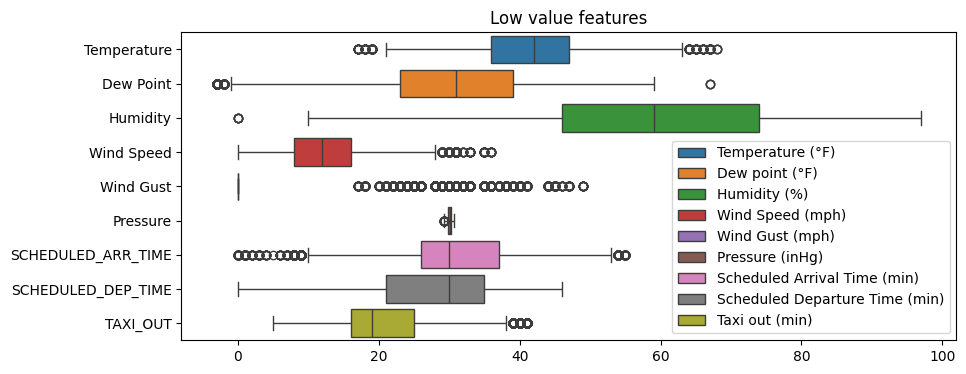

In [65]:
fig, ax = subplots(figsize=(10,4))

boxplot(jfk_lo_mean_df, orient='h')
ax.set_title('Low value features')
ax.legend(labels=['Temperature (°F)', 'Dew point (°F)', 'Humidity (%)', 'Wind Speed (mph)', 'Wind Gust (mph)', 'Pressure (inHg)', 'Scheduled Arrival Time (min)','Scheduled Departure Time (min)', 'Taxi out (min)'], loc='lower right');


Wind gusts are quite variable compared to other features.

In [66]:
# Select features with high values (mean > 60)

jfk_hi_mean_df = jfk_df.iloc[:, [7, 8, 9, 10, 11]]
jfk_hi_mean_df.describe()

,SCHEDULED_FLIGHT_DURATION,DISTANCE,SCHEDULED_DEP,ACTUAL_DEP,SCHEDULED_ARR
count,28820.000000,28820.000000,28820.000000,28820.000000,28820.000000
mean,225.288203,1267.746079,831.003851,828.934698,910.874289
std,119.482417,889.343246,299.398525,305.864103,345.411743
min,57.000000,94.000000,301.000000,1.000000,1.000000
25%,124.000000,483.000000,545.000000,542.000000,667.000000
50%,188.000000,1029.000000,856.000000,854.000000,918.000000
75%,365.000000,2248.000000,1095.000000,1097.000000,1193.000000
max,697.000000,4983.000000,1439.000000,1440.000000,1439.000000


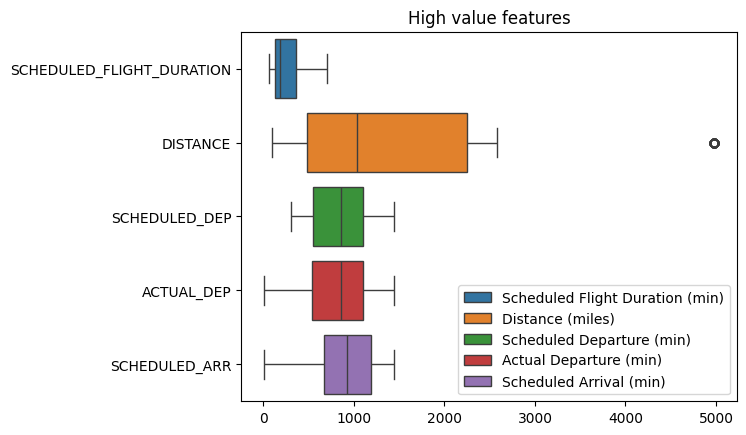

In [67]:
fig, ax = subplots()

boxplot(jfk_hi_mean_df, orient='h')
ax.set_title('High value features')
ax.legend(labels=['Scheduled Flight Duration (min)', 'Distance (miles)', 'Scheduled Departure (min)', 'Actual Departure (min)', 'Scheduled Arrival (min)'], loc='lower right');


These features are relatively stable.

count    9769.000000
mean        2.858123
std        28.422019
min       -19.000000
25%        -6.000000
50%        -4.000000
75%         0.000000
max       805.000000
Name: DEP_DELAY, dtype: float64 count    9182.000000
mean       12.339469
std        50.602727
min       -18.000000
25%        -5.000000
50%        -2.000000
75%         9.000000
max      1276.000000
Name: DEP_DELAY, dtype: float64 count    9869.000000
mean        4.306921
std        33.915495
min       -22.000000
25%        -6.000000
50%        -4.000000
75%         0.000000
max       747.000000
Name: DEP_DELAY, dtype: float64


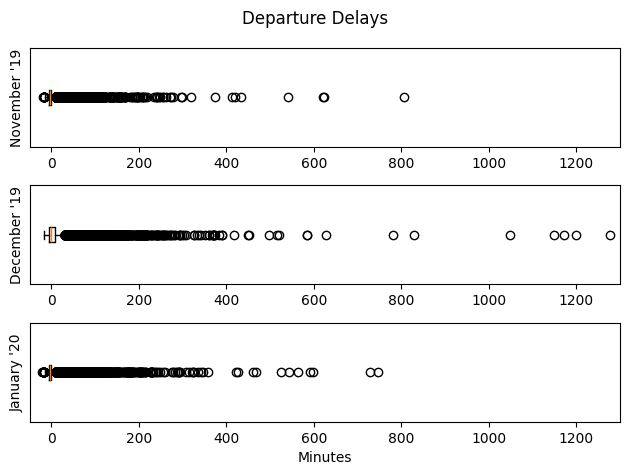

In [68]:
# Departure Delay by Month

print(nov_df['DEP_DELAY'].describe(), dec_df['DEP_DELAY'].describe(), jan_df['DEP_DELAY'].describe())

fig, ax = subplots(nrows=3, ncols=1)

ax[0].boxplot(nov_df['DEP_DELAY'], vert=False)
ax[0].set_yticks([])  # Remove y-ticks with empty array []
ax[0].set_xlim(-50, 1300)
ax[0].set_ylabel("November '19")

ax[1].boxplot(dec_df['DEP_DELAY'], vert=False)
ax[1].set_yticks([])  # Remove y-ticks with empty array []
ax[1].set_xlim(-50, 1300)
ax[1].set_ylabel("December '19")

ax[2].boxplot(jan_df['DEP_DELAY'], vert=False)
ax[2].set_yticks([])  # Remove y-ticks with empty array []
ax[2].set_xlim(-50, 1300)
ax[2].set_ylabel("January '20")
ax[2].set_xlabel('Minutes')

fig.suptitle('Departure Delays')
fig.tight_layout();

From the inter quartile range, the majority of flights were not significantly delayed.<br>
The longest delay occurred in December (1,276 minutes).<br>
December is also the month experiencing the greatest average departure delay (12.3 minutes).<br>
January had the shortest maximum delay (747 minutes) as well as the earliest departure (22 minutes).<br>
Looking at the 75% quartile for each month, most departures were on time or early in Nov and Jan, but slightly delayed in December. This is unlikely due to weather conditions (see pie chart below).

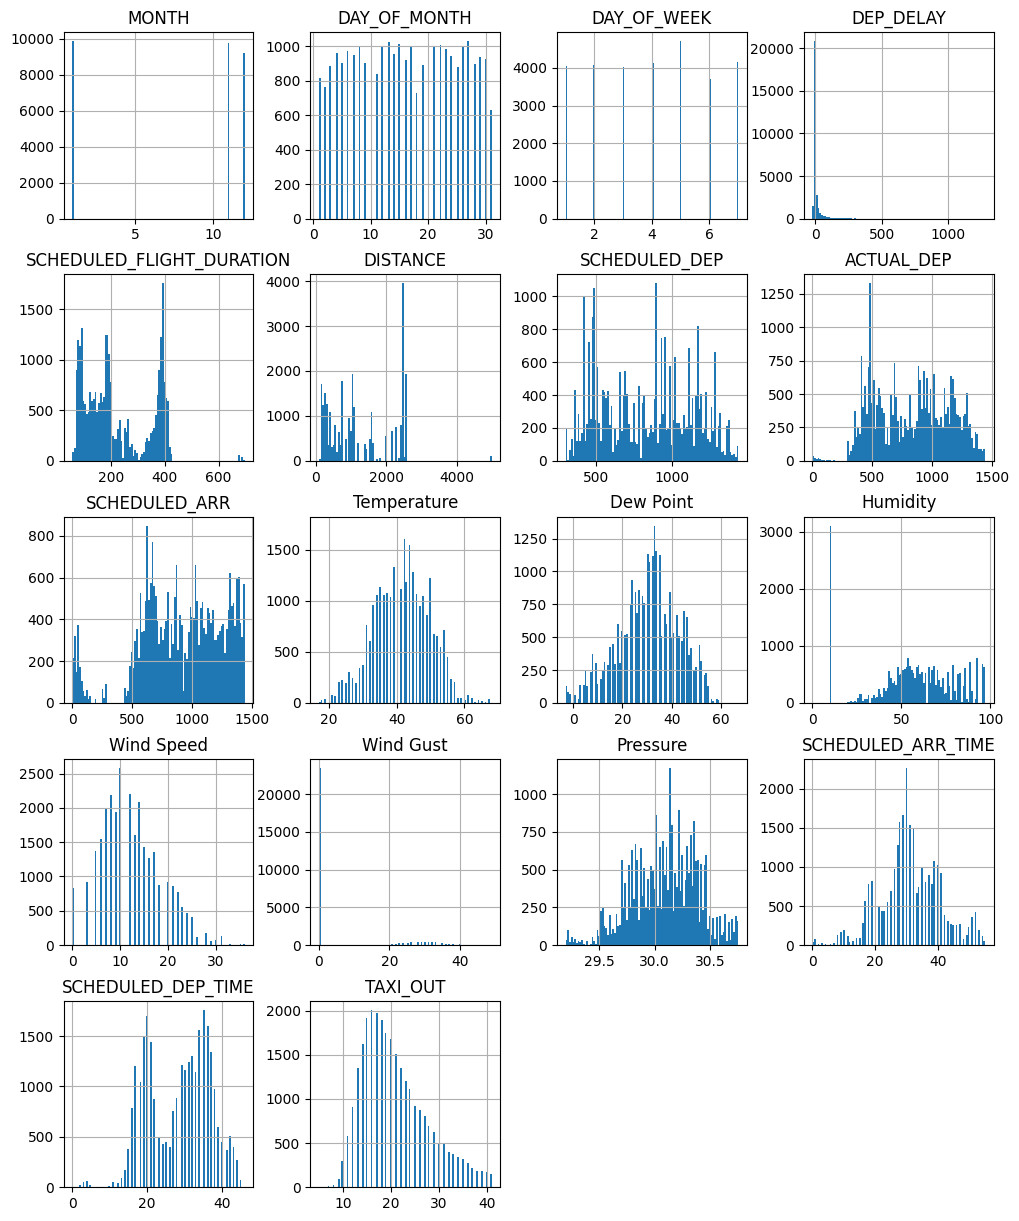

In [69]:
# Inspect frequency distribution of (numerical) flight data

jfk_df.hist(bins=100, figsize=(12,15))
fig.tight_layout();

Some interesting bimoodal distributions (to be investigated another time).

# Inspect categorical data

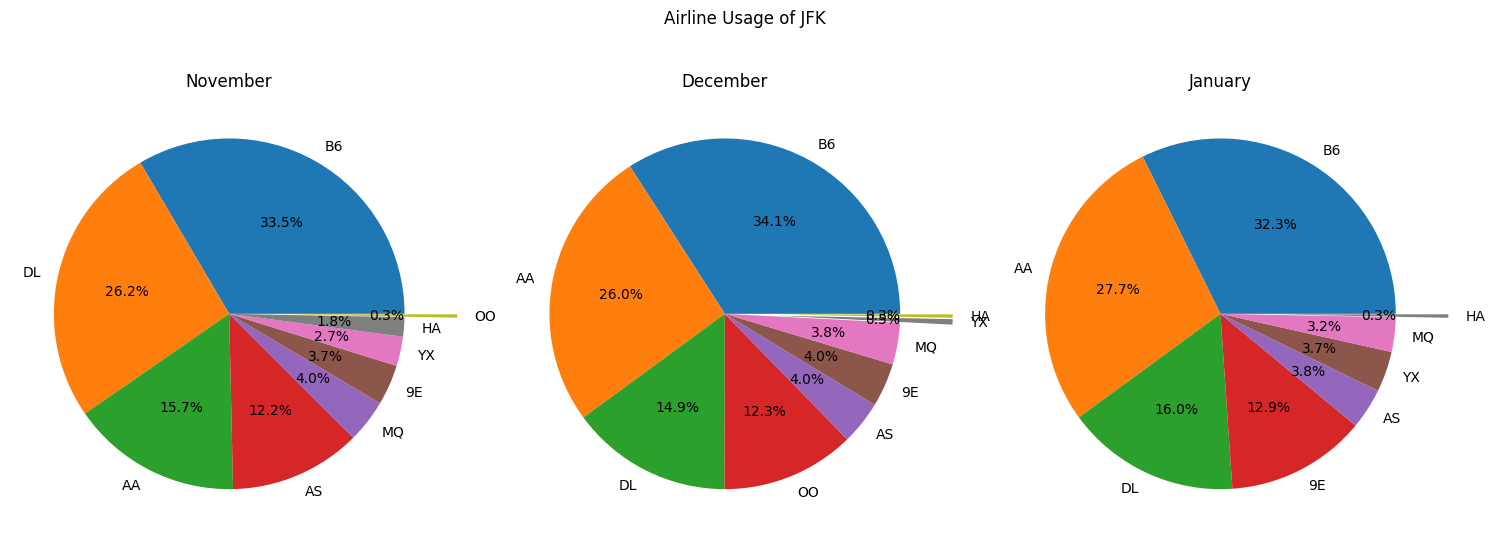

In [70]:
# Airline/Carrier usage of JFK by month

nov_car_labels = nov_df['CARRIER_CODE'].unique().tolist()  # List of the different (unique) airlines; `.tolist()` is for str, whereas `.to_list()` is for int
dec_car_labels = dec_df['CARRIER_CODE'].unique().tolist()
jan_car_labels = jan_df['CARRIER_CODE'].unique().tolist()

nov_car_freq = nov_df['CARRIER_CODE'].value_counts(normalize=True).to_list()  # List of the frequency of occurrence (counts) of each of the airlines; `.to_list()` is for int, whereas `.tolist()` is for str
dec_car_freq = dec_df['CARRIER_CODE'].value_counts(normalize=True).to_list()
jan_car_freq = jan_df['CARRIER_CODE'].value_counts(normalize=True).to_list()

nov_car_exp = [0.3 if (i < 0.01) else 0 for i in nov_car_freq]  # Specifies which pie segments to explode and how much
dec_car_exp = [0.3 if (i < 0.01) else 0 for i in dec_car_freq]
jan_car_exp = [0.3 if (i < 0.01) else 0 for i in jan_car_freq]

fig, ax = subplots(nrows=1, ncols=3, figsize=(15, 6))

ax[0].pie(nov_car_freq, labels=nov_car_labels, autopct='%1.1f%%', explode=nov_car_exp)
ax[0].set_title('November')

ax[1].pie(dec_car_freq, labels=dec_car_labels, autopct='%1.1f%%', explode=dec_car_exp)
ax[1].set_title('December')

ax[2].pie(jan_car_freq, labels=jan_car_labels, autopct='%1.1f%%', explode=jan_car_exp)
ax[2].set_title('January')

fig.suptitle('Airline Usage of JFK')
fig.tight_layout()

Three airline/carriers (B6, AA & DL) are the main users of JFK Airport during this period.

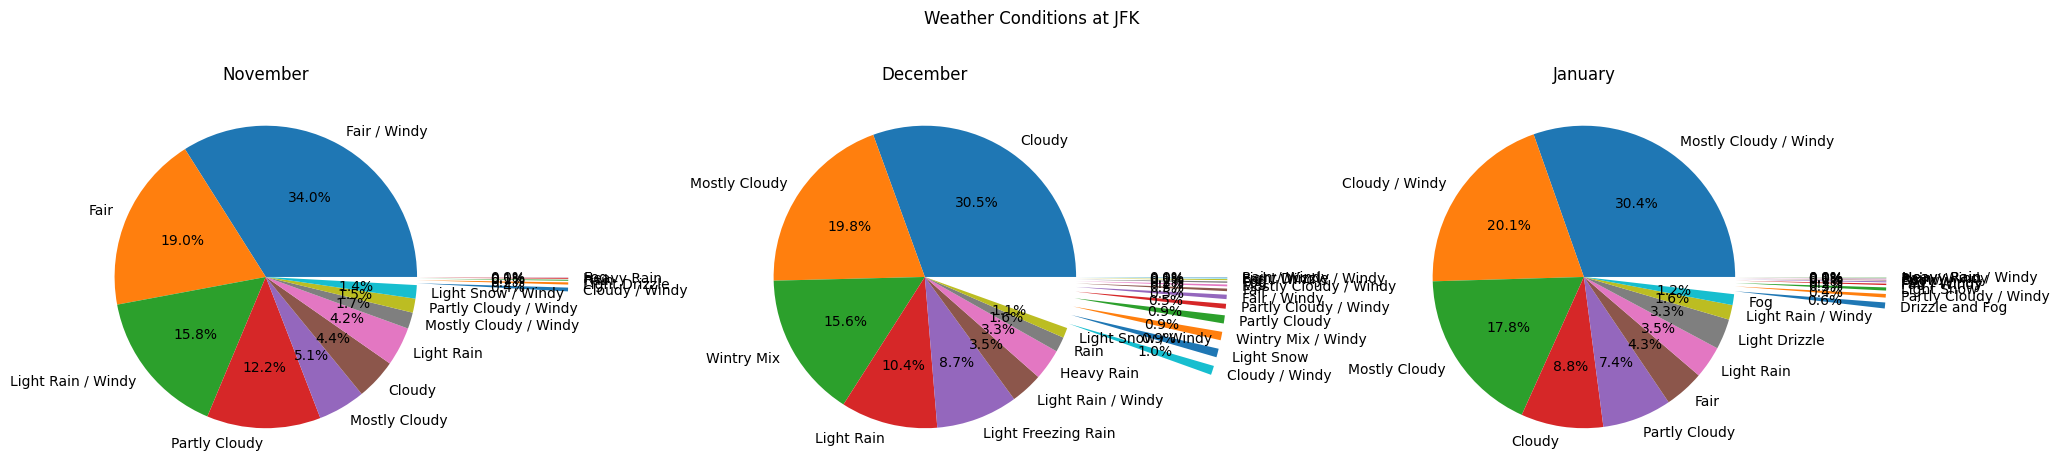

In [71]:
# Weather conditions at JFK by month

nov_con_labels = nov_df['Condition'].unique().tolist()  # List of the different (unique) airlines; `.tolist()` is for str, whereas `.to_list()` is for int
dec_con_labels = dec_df['Condition'].unique().tolist()
jan_con_labels = jan_df['Condition'].unique().tolist()

nov_con_freq = nov_df['Condition'].value_counts(normalize=True).to_list()  # List of the frequency of occurrence (counts) of each of the airlines; `.to_list()` is for int, whereas `.tolist()` is for str
dec_con_freq = dec_df['Condition'].value_counts(normalize=True).to_list()
jan_con_freq = jan_df['Condition'].value_counts(normalize=True).to_list()

nov_con_exp = [1 if (i < 0.01) else 0 for i in nov_con_freq]  # Specifies which pie segments to explode and how much
dec_con_exp = [1 if (i < 0.01) else 0 for i in dec_con_freq]
jan_con_exp = [1 if (i < 0.01) else 0 for i in jan_con_freq]

fig, ax = subplots(nrows=1, ncols=3, figsize=(20, 5))

ax[0].pie(nov_con_freq, labels=nov_con_labels, autopct='%1.1f%%', explode=nov_con_exp)
ax[0].set_title('November')

ax[1].pie(dec_con_freq, labels=dec_con_labels, autopct='%1.1f%%', explode=dec_con_exp)
ax[1].set_title('December')

ax[2].pie(jan_con_freq, labels=jan_con_labels, autopct='%1.1f%%', explode=jan_con_exp)
ax[2].set_title('January')

fig.suptitle('Weather Conditions at JFK')
fig.tight_layout()

Weather conditions were not so terrible to explain delays experienced. Most flights were not significantly delayed (see Departure Delay boxplot above).

# Taxi out

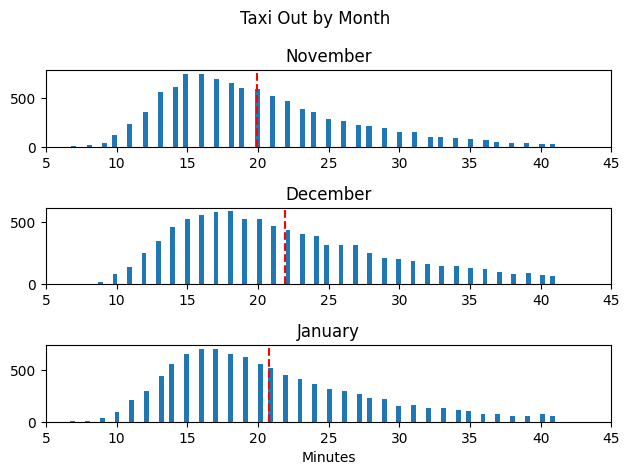

In [72]:
# Taxi Out by Month

fig, ax = subplots(3, 1)

bins = 100
x_start = 5
x_stop = 45

ax[0].hist(nov_df['TAXI_OUT'], bins=bins)
ax[0].axvline(nov_df['TAXI_OUT'].mean(), c='r', linestyle='--')
ax[0].set_xlim(x_start, x_stop)
ax[0].set_title('November')

ax[1].hist(dec_df['TAXI_OUT'], bins=bins)
ax[1].axvline(dec_df['TAXI_OUT'].mean(), c='r', linestyle='--')
ax[1].set_xlim(x_start, x_stop)
ax[1].set_title('December')

ax[2].hist(jan_df['TAXI_OUT'], bins=bins)
ax[2].axvline(jan_df['TAXI_OUT'].mean(), c='r', linestyle='--')
ax[2].set_xlim(x_start, x_stop)
ax[2].set_title('January')
ax[2].set_xlabel('Minutes');

fig.suptitle('Taxi Out by Month')
fig.tight_layout()

The red, dashed line indicates the mean.

In [23]:
jfk_df['TAXI_OUT'].describe()

count    28820.000000
mean        20.858570
std          6.851915
min          5.000000
25%         16.000000
50%         19.000000
75%         25.000000
max         41.000000
Name: TAXI_OUT, dtype: float64

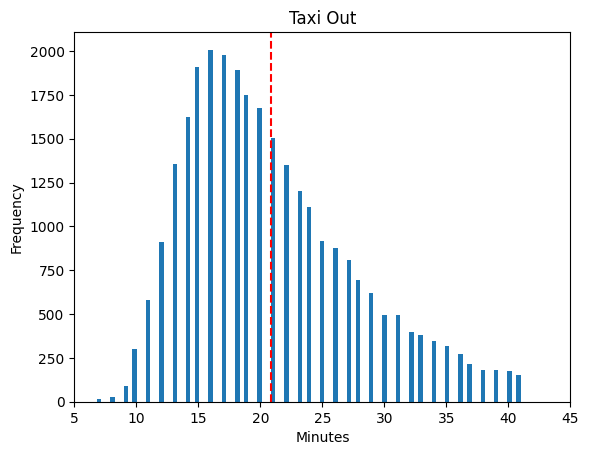

In [75]:
fig, ax = subplots()

bins = 100
x_start = 5
x_stop = 45

ax.hist(jfk_df['TAXI_OUT'], bins=bins)
ax.axvline(jfk_df['TAXI_OUT'].mean(), c='r', linestyle='--')
ax.set_xlim(x_start, x_stop)
ax.set_xlabel('Minutes')
ax.set_ylabel('Frequency')
ax.set_title('Taxi Out');

The red, dashed line indicates the mean.

In [76]:
jfk_df.groupby('MONTH').count()

,DAY_OF_MONTH,DAY_OF_WEEK,CARRIER_CODE,FLIGHT_NO,DEST,DEP_DELAY,SCHEDULED_FLIGHT_DURATION,DISTANCE,SCHEDULED_DEP,ACTUAL_DEP,SCHEDULED_ARR,Temperature,Dew Point,Humidity,Wind Direction,Wind Speed,Wind Gust,Pressure,Condition,SCHEDULED_ARR_TIME,SCHEDULED_DEP_TIME,TAXI_OUT
MONTH,,,,,,,,,,,,,,,,,,,,,,
1,9869,9869,9869,9869,9869,9869,9869,9869,9869,9869,9869,9869,9869,9869,9869,9869,9869,9869,9869,9869,9869,9869
11,9769,9769,9769,9769,9769,9769,9769,9769,9769,9769,9769,9769,9769,9769,9769,9769,9769,9769,9769,9769,9769,9769
12,9182,9182,9182,9182,9182,9182,9182,9182,9182,9182,9182,9182,9182,9182,9182,9182,9182,9182,9182,9182,9182,9182


# Pearson Correlation Matrix

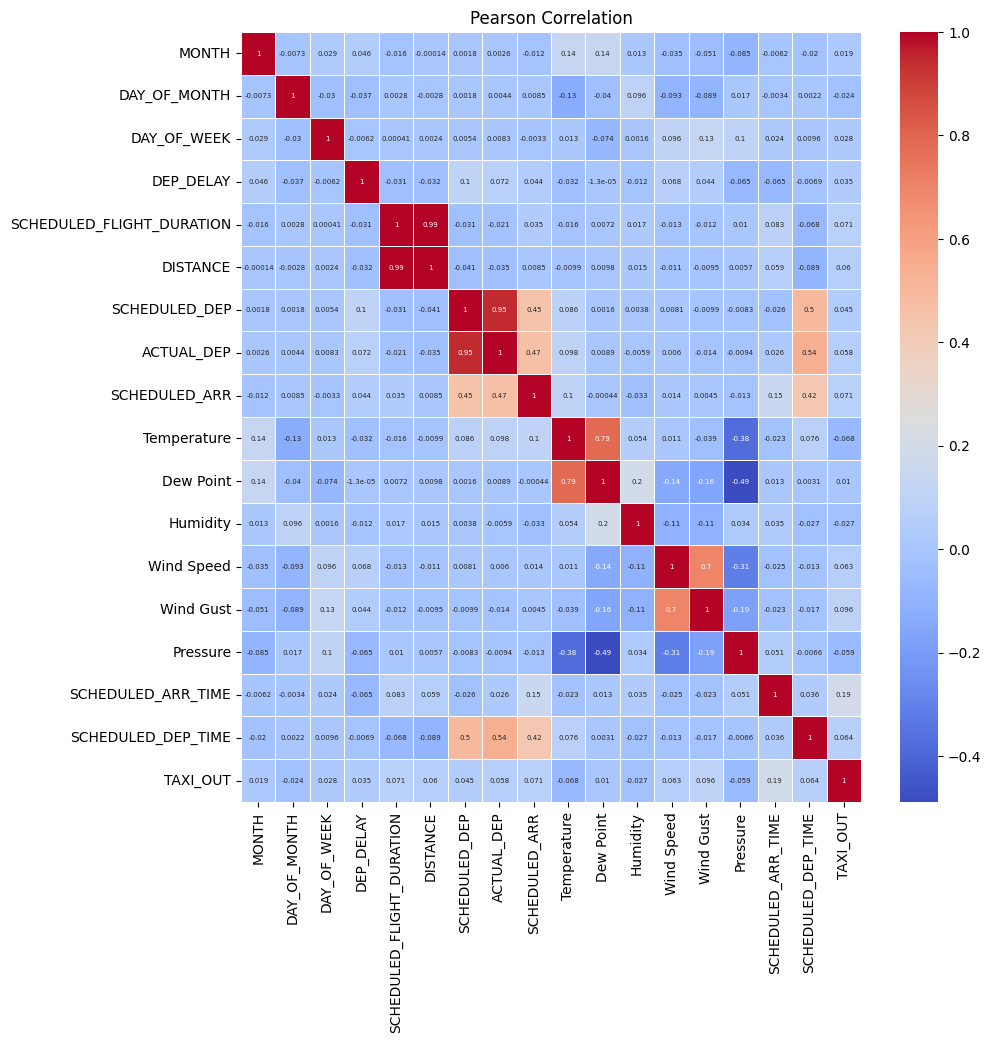

In [77]:
# Create new df excluding objects, but including int/floats
# new_df = jfk_df.select_dtypes(exclude=['object'])
# new_df.info()

# Pearson Correlation (PC) for linearity
pc_mat = jfk_df.corr(method='pearson', numeric_only=True)  # Only perform PC on numeric data ignoring objects & strings
# print(pc_mat)
fig, ax = subplots(figsize=(10,10))

heatmap(pc_mat, annot=True, annot_kws={'fontsize':5}, linewidths=0.5, cmap='coolwarm')
ax.set_title('Pearson Correlation');

Not many correlations! Modelling/predicting Taxi Out will be challenging!

# Simple Linear Regression:<br>Predicting Flight Duration from Distance

In [78]:
# X_df = jfk_df.iloc[:, 8]  # Set DISTANCE feature as X_df
X_df = jfk_df['DISTANCE']
X = X_df.to_numpy().reshape(-1,1)  # Reshape to 2D NumPy array
# print(X.shape)

# y_df = jfk_df.iloc[:, 7]  # Set SCHEDULED_FLIGHT_DURATION as class
y_df = jfk_df['SCHEDULED_FLIGHT_DURATION']
y = y_df.to_numpy().reshape(-1,1)
# y.shape

# Won't scale since of similar magnitude

In [79]:
RANDOM_STATE = 111
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=RANDOM_STATE)
# print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

lr = LinearRegression()

lr.fit(X_train, y_train)  # Train

y_pred = lr.predict(X_test)  # Predict

r2 = round(r2_score(y_test, y_pred), 3)  # Evaluate with R^2


      Actual Flight Duration  Predicted Flight Duration
6914                     179                 190.201374
4629                      85                  80.952644
7340                     367                 356.211363
7233                     189                 190.201374
2398                     166                 157.480177
1323                     374                 386.528554
6877                     405                 401.353259
2982                     685                 721.486763
1122                     124                 113.006061
7914                     142                 134.642117
5392                     239                 269.400025
4187                      75                  91.503560
4937                     186                 182.054464
140                      124                 113.006061
323                      412                 401.353259
1076                     330                 321.753940
658                      187                 198

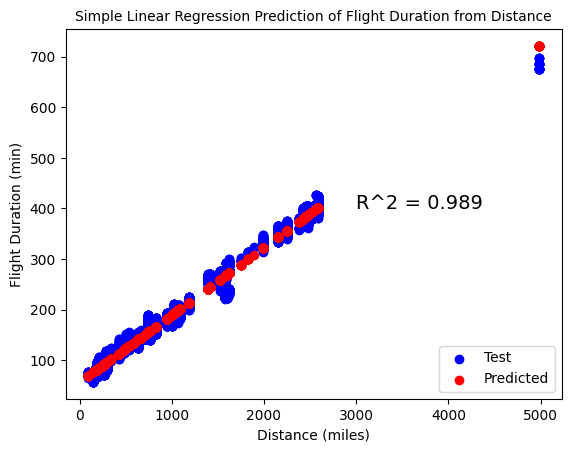

In [80]:
# Evaluate prediction

y_compare = DataFrame({'Actual Flight Duration': y_test.ravel(), 'Predicted Flight Duration': y_pred.ravel()})
print(y_compare.sample(20))

fig, ax = subplots()

ax.scatter(X_test, y_test, c='b')
ax.scatter(X_test, y_pred, c='r')
ax.legend(['Test', 'Predicted'], loc='lower right')
ax.set_xlabel('Distance (miles)')
ax.set_ylabel('Flight Duration (min)')
ax.set_title('Simple Linear Regression Prediction of Flight Duration from Distance', fontsize=10)
ax.text(3000, 400, f'R^2 = {r2}', fontsize=14);

# Simple Linear Regression:<br>Predicting Actual Departure from Scheduled Departure, Scheduled Arrival & Scheduled Departure Time

In [81]:
X_df = jfk_df[['SCHEDULED_DEP', 'SCHEDULED_ARR', 'SCHEDULED_DEP_TIME']]
X = X_df.to_numpy()
print(X.shape)

y_df = jfk_df['ACTUAL_DEP']
y = y_df.to_numpy().reshape(-1,1)
print(y.shape)

(28820, 3)
(28820, 1)


In [82]:
# Train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=RANDOM_STATE)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(20174, 3) (8646, 3) (20174, 1) (8646, 1)


In [83]:
# Need to scale. Use StandardScaler

stdscl = StandardScaler()
X_train_scaled = stdscl.fit_transform(X_train)
# print(X_train_scaled)

X_test_scaled = stdscl.transform(X_test)
# print(X_test_scaled)


In [84]:
lr = LinearRegression()

lr.fit(X_train_scaled, y_train)

y_pred = lr.predict(X_test_scaled)

      Actual Departure  Predicted Departure
8226              1072          1061.170377
695                743           741.095102
8125               601          1163.508328
8603               550           515.541363
4648               468           492.467943
4560               670           646.495109
838               1242          1205.709822
2211              1315          1286.469691
444                961           961.883162
8275               506           479.581889
2716               893           930.684877
5506               441           496.869763
1720               709           685.965841
3636              1130          1137.044421
7096               686           661.156276
1577              1177          1160.383717
7760               653           644.896437
6598              1290          1244.422844
1332               502           496.589929
7305               925           943.737392
MAE: 33.3
MSE: 9592.0
R^2: 0.899


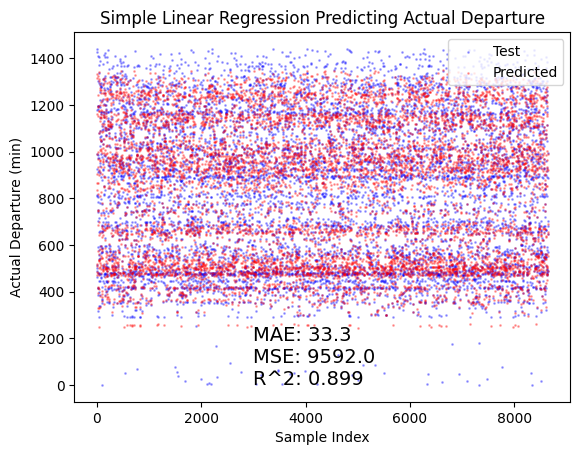

In [86]:
# Evaluate prediction

y_compare = DataFrame({'Actual Departure': y_test.ravel(), 'Predicted Departure': y_pred.ravel()})
print(y_compare.sample(20))

mae = round(mean_absolute_error(y_test, y_pred), 1)  # Evaluate Mean Absolute Error
mse = round(mean_squared_error(y_test, y_pred), 1)  # Evaluate Mean Square Error
r2 = round(r2_score(y_test, y_pred), 3)  # Evaluate with R^2
print(f"MAE: {mae}\nMSE: {mse}\nR^2: {r2}")

fig, ax =subplots()

ax.scatter(y_compare.index, y_test, s=1, c='b', alpha=0.3)
ax.scatter(y_compare.index, y_pred, s=1, c='r', alpha=0.3)
ax.legend(['Test', 'Predicted'], loc='upper right')
ax.set_title('Simple Linear Regression Predicting Actual Departure')
ax.set_xlabel('Sample Index')
ax.set_ylabel('Actual Departure (min)')
ax.text(3000, 0, f"MAE: {mae}\nMSE: {mse}\nR^2: {r2}", fontsize=14);

# LassoCV Regularisation

In [36]:
# Repeat k-fold Cross validation
RANDOM_STATE = 111
nsplits = 10
nrepeats = 10

cv = RepeatedKFold(n_splits=nsplits, n_repeats=nrepeats, random_state=RANDOM_STATE)

# Instantiate and train model
lasso_cv = LassoCV(alphas=arange(0.1,10,0.01), cv=cv, n_jobs=-1)

lasso_cv.fit(X_train_scaled, y_train.ravel())  # y_train needs to be 1D array

# Return optimal alpha
print(f"The alpha that minimises the MSE = {lasso_cv.alpha_}")

The alpha that minimises the MSE = 0.1


(8646,)
      Actual Departure  Predicted Departure
5786               677           667.645941
3030               484           467.617474
7495               506           502.818052
3524               592           573.833101
7165              1163          1164.409205
3487               654           654.202299
2264              1027          1040.454646
1299               649           627.735909
2339               416           425.572293
7822               809           858.307070
373                922           927.662605
3236               626           617.922875
6405              1147          1129.450011
1826               998           991.908388
7262              1099          1103.074999
6010              1164          1157.033657
6287               882           905.441866
3366              1331          1278.965350
203                698           688.466448
5446              1176          1158.026228
MAE: 33.3
MSE: 9592.0
R^2: 0.899


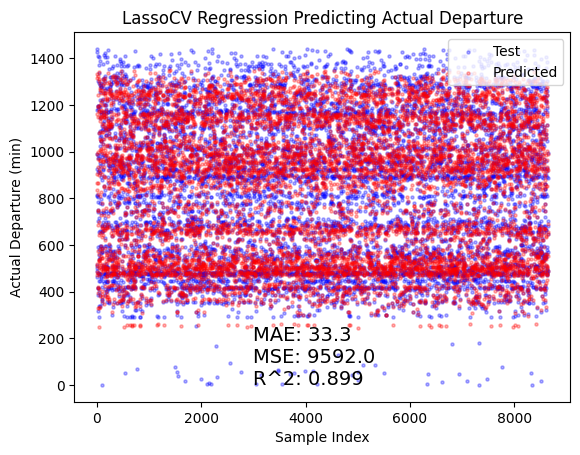

In [37]:
# Predict

y_pred_lcv = lasso_cv.predict(X_test_scaled)
print(y_pred_lcv.shape)


y_compare_lcv = DataFrame({'Actual Departure': y_test.ravel(), 'Predicted Departure': y_pred_lcv})
print(y_compare_lcv.sample(20))

mae_lcv = round(mean_absolute_error(y_test, y_pred_lcv), 1)  # Evaluate Mean Absolute Error
mse_lcv = round(mean_squared_error(y_test, y_pred_lcv), 1)  # Evaluate Mean Square Error
r2_lcv = round(r2_score(y_test, y_pred_lcv), 3)  # Evaluate with R^2
print(f"MAE: {mae_lcv}\nMSE: {mse_lcv}\nR^2: {r2_lcv}")

fig, ax =subplots()

ax.scatter(y_compare_lcv.index, y_test, s=5, c='b', alpha=0.3)
ax.scatter(y_compare_lcv.index, y_pred_lcv, s=5, c='r', alpha=0.3)
ax.legend(['Test', 'Predicted'], loc='upper right')
ax.set_title('LassoCV Regression Predicting Actual Departure')
ax.set_xlabel('Sample Index')
ax.set_ylabel('Actual Departure (min)')
ax.text(3000, 0, f"MAE: {mae_lcv}\nMSE: {mse_lcv}\nR^2: {r2_lcv}", fontsize=14);


# RidgeCV Regularisation

In [38]:
# Repeat k-fold Cross validation
RANDOM_STATE = 111
nsplits = 5
nrepeats = 5

cv = RepeatedKFold(n_splits=nsplits, n_repeats=nrepeats, random_state=RANDOM_STATE)

# Instantiate and train model
ridge_cv = RidgeCV(alphas=arange(0.1,10,0.01), cv=cv, scoring='neg_mean_absolute_error')

ridge_cv.fit(X_train_scaled, y_train)  # y_train needs to be 1D array

# Return optimal alpha
print(f"The alpha that minimises the MSE = {ridge_cv.alpha_}")

The alpha that minimises the MSE = 0.1


(8646,)
      Actual Departure  Predicted Departure
3097               922           953.524541
4352               466           504.800883
645                731           608.344097
7863               576           556.376311
7897              1064          1053.596772
8621               578           560.972384
2897               806           836.283703
5652              1249          1269.998287
1820              1010          1007.556323
7256               704           694.316960
8218              1194          1175.646122
6186              1093          1081.245238
8272              1270          1226.173778
2899               611           597.031377
4777               389           397.254115
2280              1253          1252.995224
6985              1339          1184.392039
2591               327           346.012895
1467               543           525.423627
5780              1284          1223.494638
MAE: 33.3
MSE: 9592.0
R^2: 0.899


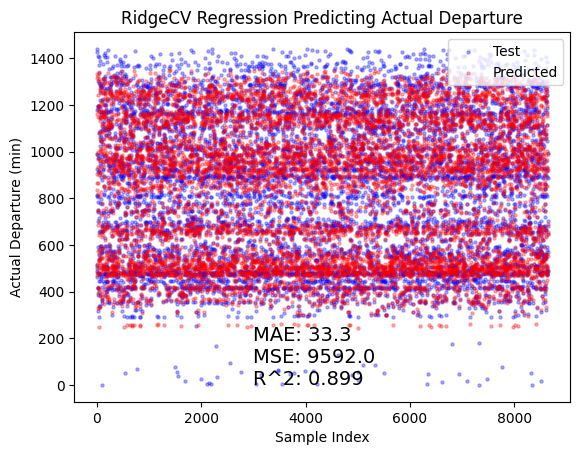

In [39]:
# Predict

y_pred_rcv = ridge_cv.predict(X_test_scaled)
print(y_pred_rcv.shape)


y_compare_rcv = DataFrame({'Actual Departure': y_test.ravel(), 'Predicted Departure': y_pred_rcv})
print(y_compare_rcv.sample(20))

mae_rcv = round(mean_absolute_error(y_test, y_pred_rcv), 1)  # Evaluate Mean Absolute Error
mse_rcv = round(mean_squared_error(y_test, y_pred_rcv), 1)  # Evaluate Mean Square Error
r2_rcv = round(r2_score(y_test, y_pred_rcv), 3)  # Evaluate with R^2
print(f"MAE: {mae_rcv}\nMSE: {mse_rcv}\nR^2: {r2_rcv}")

fig, ax =subplots()

ax.scatter(y_compare_rcv.index, y_test, s=5, c='b', alpha=0.3)
ax.scatter(y_compare_rcv.index, y_pred_lcv, s=5, c='r', alpha=0.3)
ax.legend(['Test', 'Predicted'], loc='upper right')
ax.set_title('RidgeCV Regression Predicting Actual Departure')
ax.set_xlabel('Sample Index')
ax.set_ylabel('Actual Departure (min)')
ax.text(3000, 0, f"MAE: {mae_rcv}\nMSE: {mse_rcv}\nR^2: {r2_rcv}", fontsize=14);

# Simple Linear Regression:<br>Predicting Taxi Out from Scheduled Arrival Time

In [87]:
X_df = jfk_df['SCHEDULED_ARR_TIME']
X = X_df.to_numpy().reshape(-1,1)  # Reshape to 2D NumPy array
# print(X.shape)

y_df = jfk_df['TAXI_OUT']
y = y_df.to_numpy().reshape(-1,1)
# y.shape


In [88]:
# No need to scale since values are of similar magnitude

RANDOM_STATE = 111
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=RANDOM_STATE)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

lr = LinearRegression()

lr.fit(X_train, y_train)  # Train

y_pred = lr.predict(X_test)  # Predict

r2 = round(r2_score(y_test, y_pred), 3)  # Evaluate with R^2

(20174, 1) (8646, 1) (20174, 1) (8646, 1)


      Actual Taxi Out  Predicted Taxi Out
573                20           20.045815
7108               18           19.363293
556                17           20.591833
8104               11           19.090284
3056               24           21.820373
7557               12           20.591833
3514               16           20.455329
2828               27           22.229887
6775               27           21.001347
7632               20           19.363293
3430               18           20.045815
1310               18           20.045815
1431               34           21.410860
3154               22           22.229887
1096               15           21.956878
2330               22           20.591833
5644               36           21.820373
3779               23           19.772806
4519               23           20.318824
4762               21           20.455329


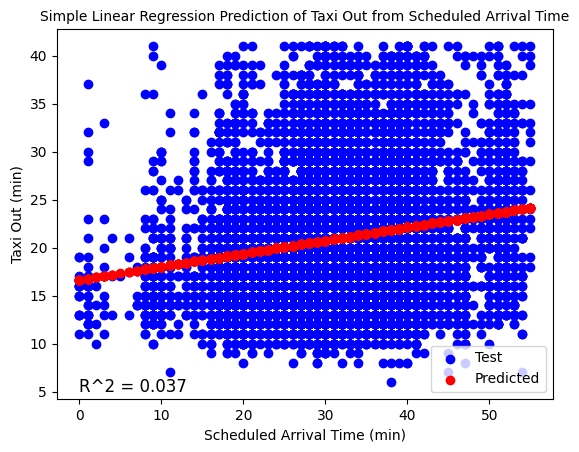

In [89]:
# Evaluate prediction

y_compare = DataFrame({'Actual Taxi Out': y_test.ravel(), 'Predicted Taxi Out': y_pred.ravel()})
print(y_compare.sample(20))

fig, ax = subplots()

ax.scatter(X_test, y_test, c='b')
ax.scatter(X_test, y_pred, c='r')
ax.legend(['Test', 'Predicted'], loc='lower right')
ax.set_xlabel('Scheduled Arrival Time (min)')
ax.set_ylabel('Taxi Out (min)')
ax.set_title('Simple Linear Regression Prediction of Taxi Out from Scheduled Arrival Time', fontsize=10)
ax.text(0, 5, f'R^2 = {r2}', fontsize=12);